In [1]:
from import_libraries import *

Sourcing files from flv-c servers


In [2]:
from import_data import import_from_flv_utils

data = import_from_flv_utils()  # by default this function loads all data where "M3" is labelled with a confidence of >=1
data.keys()

dict_keys(['all', 'sparse_food', 'off_food', 'just_fed', 'fasted', '1h_starved'])

## Do forward run durations differ across imaging conditions?

In [51]:
from bootstrap import *
from events import *

def plot_fwd_duration_ecdf(list_groups, list_colors):

    # Create the plot with bootstrap confidence intervals
    plt.figure(figsize=(6, 5))

    for i, group in enumerate(list_groups):

        group_data = get_fwd_rev_durations(data[group])

        # Get the list of animal data arrays
        animal_data_list = group_data['fwd_durations']
        n_animals = len(animal_data_list)

        # Calculate bootstrap confidence intervals (100 bootstrap samples)
        x_vals, ecdf_vals, bootstrap_ecdfs, lower_ci, upper_ci = bootstrap_ecdf_by_animal(
            animal_data_list, n_bootstrap=100, confidence_level=0.95
        )

        group_data['fwd_duration_ecdf'] = ecdf_vals
        group_data['bootstrap_ecdfs']   = bootstrap_ecdfs

        # Plot ECDF line
        plt.plot(x_vals, ecdf_vals, color=group_colors[i], linewidth=3, 
                 label=f'{group}:\n{n_animals} animals; {len(np.concatenate(animal_data_list))} FWD runs')

        # Plot confidence interval as shaded region
        plt.fill_between(x_vals, lower_ci, upper_ci, color=group_colors[i], alpha=0.2)


    plt.axvline([17])
    plt.axvline([24])
    plt.xlabel('Duration (minutes)', fontsize=14, fontweight='bold')
    plt.ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
    plt.title('Forward Run Durations\n(95% CI by Bootstrapping across Animals)', fontsize=16, fontweight='bold')
    plt.xticks([0, 50, 100, 150, 200], 
               [0, 0.5, 1,  1.5, 2], fontsize=12)
    plt.yticks(fontsize=12)
    # plt.xscale('log', base=2)
    plt.xlim(2, 200)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

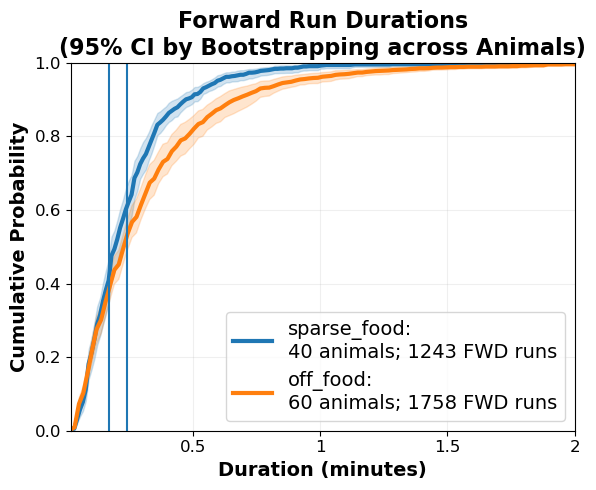

In [52]:
list_groups  = ['sparse_food', 'off_food']
group_colors = ['#1f77b4', '#ff7f0e']  # Blue and orange
plot_fwd_duration_ecdf(list_groups, group_colors)

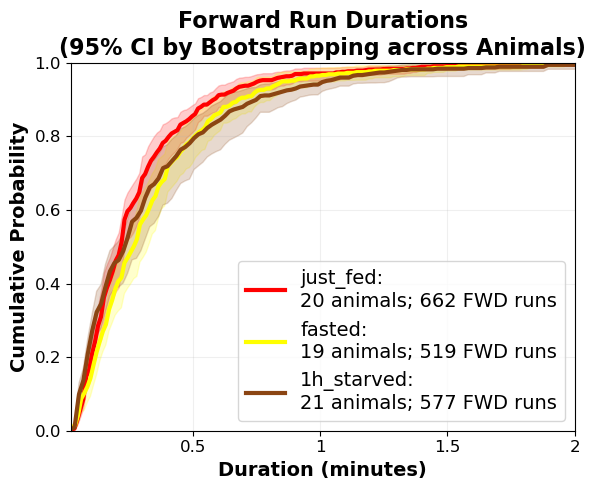

In [5]:
list_groups  = ['just_fed', 'fasted', '1h_starved']
group_colors = ['red', 'yellow', '#8B4513']  # Red, Gold, Saddle Brown
plot_fwd_duration_ecdf(list_groups, group_colors)

## Do reversal durations differ across imaging conditions?

In [48]:
def plot_rev_duration_ecdf(list_groups, list_colors):
    # Create the plot with bootstrap confidence intervals
    plt.figure(figsize=(6, 5))

    for i, group in enumerate(list_groups):

        group_data = get_fwd_rev_durations(data[group])

        # Get the list of animal data arrays
        animal_data_list = group_data['rev_durations']
        n_animals = len(animal_data_list)

        # Calculate bootstrap confidence intervals (100 bootstrap samples)
        x_vals, ecdf_vals, bootstrap_ecdfs, lower_ci, upper_ci = bootstrap_ecdf_by_animal(
            animal_data_list, n_bootstrap=100, confidence_level=0.95
        )

        group_data['rev_duration_ecdf'] = ecdf_vals
        group_data['bootstrap_ecdfs']   = bootstrap_ecdfs

        # Plot ECDF line
        plt.plot(x_vals, ecdf_vals, color=group_colors[i], linewidth=3, 
                 label=f'{group}:\n{n_animals} animals; {len(np.concatenate(animal_data_list))} REV')

        # Plot confidence interval as shaded region
        plt.fill_between(x_vals, lower_ci, upper_ci, color=group_colors[i], alpha=0.2)

    plt.axvline([10])
    plt.axvline([13])
    plt.xlabel('Duration (minutes)', fontsize=14, fontweight='bold')
    plt.ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
    plt.title('Reversal Durations\n(95% CI by Bootstrapping across Animals)', fontsize=16, fontweight='bold')
    plt.xticks([0, 50, 100, 150, 200], 
               [0, 0.5, 1,  1.5, 2], fontsize=12)
    plt.yticks(fontsize=12)
    # plt.xscale('log', base=2)
    plt.xlim(2, 100)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

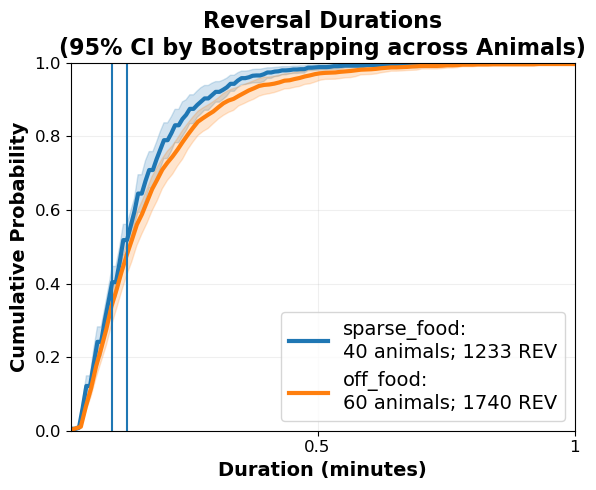

In [49]:
list_groups  = ['sparse_food', 'off_food']
group_colors = ['#1f77b4', '#ff7f0e']  # Blue and orange
plot_rev_duration_ecdf(list_groups, group_colors)

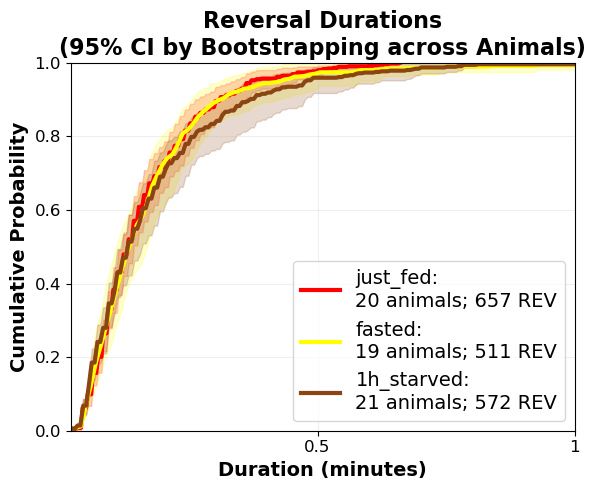

In [8]:
list_groups  = ['just_fed', 'fasted', '1h_starved']
group_colors = ['red', 'yellow', '#8B4513']  # Red, Gold, Saddle Brown
plot_rev_duration_ecdf(list_groups, group_colors)

## Do long reversals preceed long forward runs?

In [20]:
def correlate_fwd_rev_durations(data, group, scale='log2'):
    group_data = get_fwd_rev_durations(data[group])
    all_fwd_dur = []
    all_rev_dur = []
    
    for i in range(len(group_data['animal_uid'])):
        if group_data['first_event'][i] == 'fwd':
            fwd_dur = group_data['fwd_durations'][i][1:]            # drop the first forward run
            rev_dur = group_data['rev_durations'][i]
        elif group_data['first_event'][i] == 'rev':
            rev_dur = group_data['rev_durations'][i]
            fwd_dur = group_data['fwd_durations'][i]
        
        n_events = min(len(fwd_dur), len(rev_dur))
        all_fwd_dur.extend(fwd_dur[:n_events])
        all_rev_dur.extend(rev_dur[:n_events])
        plt.scatter(fwd_dur[:n_events], rev_dur[:n_events], alpha=0.2)

    correlation, p_value = spearmanr(all_fwd_dur, all_rev_dur)

    if scale=='log2':
        plt.xscale('log', base=2)
        plt.yscale('log', base=2)
    plt.title(f'{group}: n = {len(group_data['animal_uid'])} animals, spearman = {correlation:.2f}', fontweight='bold', fontsize=16)
    plt.xlim(1.7,300)
    plt.ylim(1.7,100)
    plt.xlabel('Forward run durations\n(log2 scale)', fontsize=14)
    plt.ylabel('Reversal durations\n(log2 scale)', fontsize=14)

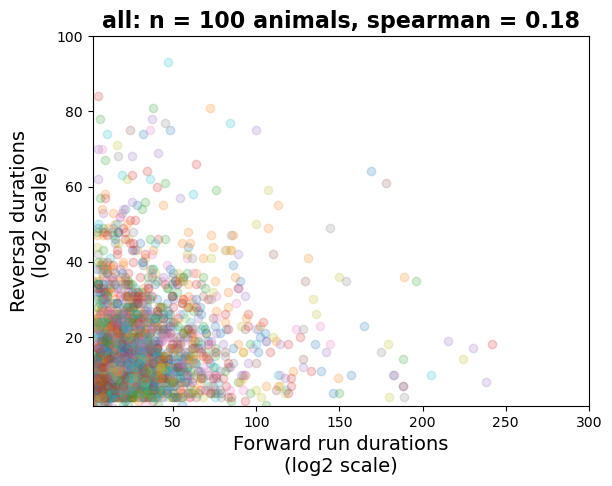

In [21]:
group = 'all'
correlate_fwd_rev_durations(data, group, scale='normal')

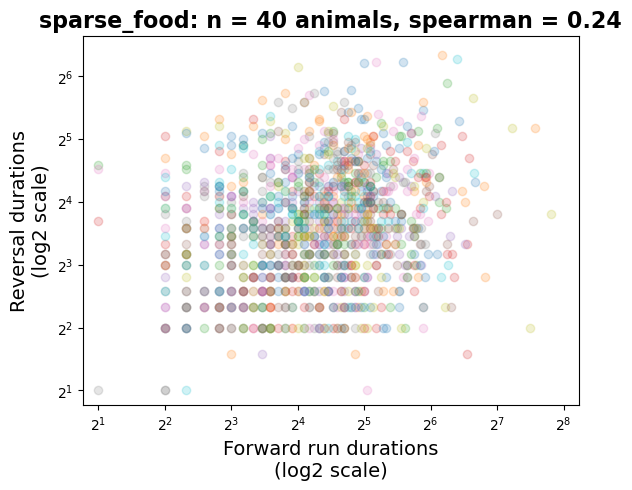

In [14]:
group = 'sparse_food'
correlate_fwd_rev_durations(data, group)

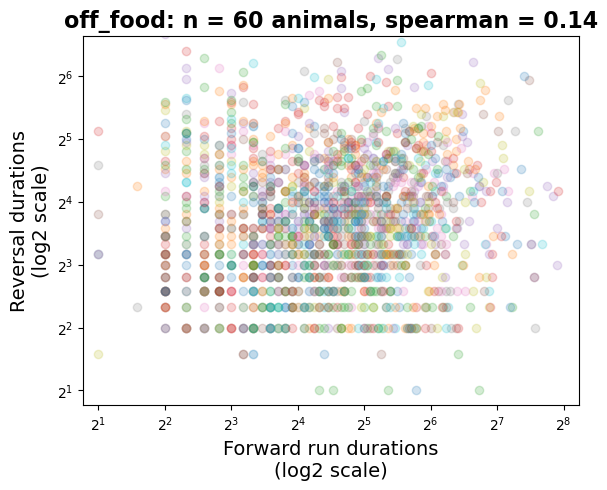

In [15]:
group = 'off_food'
correlate_fwd_rev_durations(data, group)

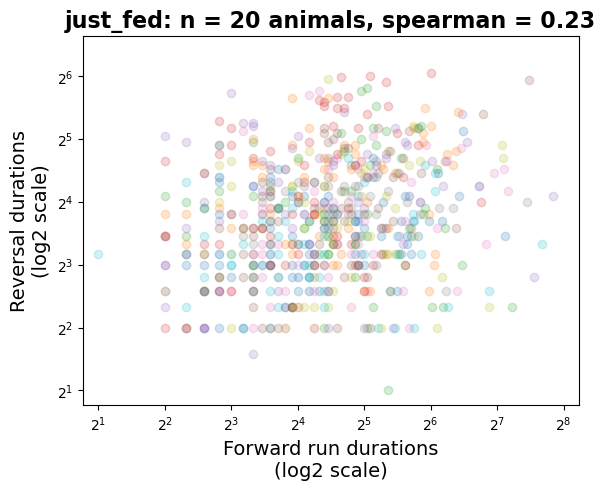

In [16]:
group = 'just_fed'
correlate_fwd_rev_durations(data, group)

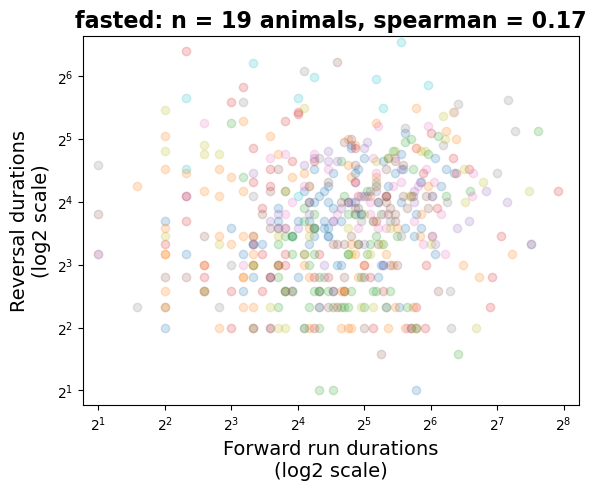

In [17]:
group = 'fasted'
correlate_fwd_rev_durations(data, group)

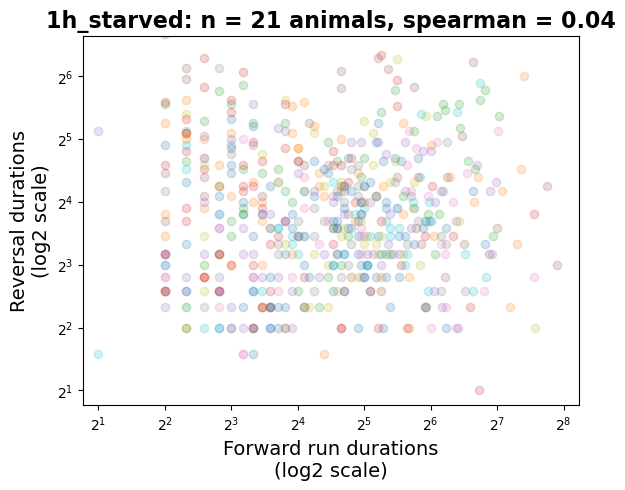

In [18]:
group = '1h_starved'
correlate_fwd_rev_durations(data, group)